1° Progetto Social Computing

 
Importiamo le librerie necessarie

In [24]:
import pandas as pd
import networkx as nx
import pyvis as pv
import json
import numpy as np
from serpapi import GoogleScholarSearch
import pickle
import matplotlib.pyplot as plt

GoogleScholarSearch.SERP_API_KEY = 'MY_KEY' #Davide SERP KEY
df = pd.read_csv("data\\nodes.csv")  #read nodes.csv


1. A partire da nodes.csv, utilizzare la libreria Python SerpAPI per scaricare, per
ciascuno dei 7 autori elencati:
- author_id: ID identificativo del profilo Google Scholar
- cited_by: numero totale di citazioni ricevute
- interests: elenco degli interessi di ciascun autore
    
Sfruttando la libreria Python Pandas, usare la struttura dati DataFrame per
aggiornare il file originale con apposite colonne e memorizzarlo nella cartella
/data.


1.1 Scaricare author_id : ID identificativo del profilo Google Scholar

In [25]:
search = []
result = []
aff = [] 
name_authors = []
name_coauthors_per_author = [] 
for index, row in df.iterrows():
    params = {"engine": "google_scholar_profiles", "hl": 'en', "mauthors": row['name']}
    search.append(GoogleScholarSearch(params))  
    result.append(search[index].get_dict()) 
    aff.append(row['affiliations'])
    name_authors.append(row['name'])
    name_coauthors_per_author.append([row['name']])

1.2 Scaricare cited_by: numero totale di citazioni ricevute

1.3 Scaricare interests: elenco degli interessi di ciascun autore

In [26]:
author = []
cited = []
interests = []
for index_result, value_result in enumerate(result): 
    for value_profiles in result[index_result]['profiles']: 
        interests_per_person = [] 
        if (value_profiles['affiliations']) == aff[index_result]:  
                                                                  
            author.append(value_profiles['author_id'])
            cited.append(value_profiles['cited_by'])

            for i in value_profiles['interests']: 
                interests_per_person.append(i['title'])
            
            interests.append(interests_per_person)

Sfruttando la libreria Python Pandas, usare la struttura dati DataFrame per
aggiornare il file originale con apposite colonne e memorizzarlo nella cartella
/data.

In [27]:
df['author_id'] = author
df['cited_by'] = cited
df['interests'] = interests
df.to_csv("data\\nodes.csv", index = False)

2. Per ciascuno dei 7 autori, utilizzare il suo ID per accedere al relativo profilo Google
Scholar e scaricare l’elenco dei suoi coautori, sempre via SerpAPI. Con tale elenco
di nomi:

    a. Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che corrisponde a tale nome. Per ciascuno, salvare name, affiliations, author_id cited_by e interests in un nuovo DataFrame contenente tutte queste informazioni relative ai coautori dei 7 autori originari.

    b. Concatenare il DataFrame con i 7 autori originari e quello dei coautori generato al punto 2a in un unico DataFrame. NOTA BENE: è sufficiente effettuare la ricerca dei profili per nome, non accedere al loro profilo tramite id. ASSUNZIONE: in questo caso non potete identificare il profilo corretto tramite il valore di affiliations, quindi assumete che quello corretto sia il primo ritornato nella lista di authors.

    c. Creare un terzo DataFrame con le colonne author1, author2 che rappresenta le co-authorship. In tale DataFrame, una riga rappresenta un arco di coauthorship tra due autori.

ESEMPIO: David La Barbera, Michael Soprano è una riga del DataFrame
creato al punto 2c se Michael Soprano è coautore di David La Barbera. La
co-authorship è binaria, non pesata.


A questo punto avrete prodotto due DataFrame:
- Uno per le informazioni relative agli autori (originali + i relativi coautori) e
contenente per ciascuno di essi i valori di name, affiliations, cited_by,
interests. Salvare come nodes.csv nella cartella /data tale DataFrame.
- Uno per le relazioni di co-authorship dai 7 autori principali verso i relativi
coautori con colonne author1, author2. Salvare come edges.csv nella
cartella /data tale DataFrame.

a. Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che corrisponde a tale nome. Per ciascuno, salvare name, affiliations, author_id, cited_by e interests in un nuovo DataFrame contenente tutte queste informazioni relative ai coautori dei 7 autori originari.

In [28]:
search = []
result = []
coauthors = []
for index, value in enumerate(author):
    params = {"engine": "google_scholar_author", "hl": 'en', "author_id": value}
    search.append(GoogleScholarSearch(params))
    result.append(search[index].get_dict())
    coauthors.append(result[index]['co_authors'])

 
Per ognuno dei 7 autori, scarichiamo i profili dei loro coautori

In [29]:
for index_author, value_author in enumerate(coauthors): #for each author
    coauthors_names = []
    for index_coauthor, value_coauthor in enumerate(coauthors[index_author]): #for each coauthor of the selected author
        coauthors_names.append(value_coauthor['name']) #save the name of the coauthor

    name_coauthors_per_author[index_author] = coauthors_names #list of coauthor grouped by authors
    


In base all'elenco dei coautori ricerchiamo i nominativi su google scholar

In [32]:
search = []
result = []
count = 0
for index, value in enumerate(name_coauthors_per_author): #for each coauthor list of an author
    for i, v in enumerate(value): #for each coauthor of a coauthor list
        params = {"engine": "google_scholar_profiles", "hl": 'en', "mauthors": v}
        search.append(GoogleScholarSearch(params))
        result.append(search[count].get_dict())#search[count] perché con search[i], finito il loop interno, ripartivano gli indici da 0-->es. result[9] = search[0] e quindi riscrivevo gli stessi autori
        print(search[count].get_dict()["profiles"][0]["name"])
        count += 1

Kevin Roitero
Stefano Mizzaro
Gianluca Demartini
Damiano Spina
Michael Soprano
Vincenzo Della Mea
Davide Ceolin
Tim Draws
Joel Mackenzie
Kevin Roitero
Stefano Mizzaro
Gianluca Demartini
Damiano Spina
Davide Ceolin
David La Barbera
Vincenzo Della Mea
Beatrice Portelli
Giuseppe Serra
Shaoyang Fan
Giuseppe Primiero
Jan Wielemaker
Tim Draws
Alessandro Checco
Afshin Rahimi
Andrea Brunello
Tetsuya Sakai
Maddalena Zippi
Stefano Mizzaro
Gianluca Demartini
Michael Soprano
Maddalena Zippi
Vincenzo Della Mea
Damiano Spina
David La Barbera
Alessandro Checco
Beatrice Portelli
Mihai Horia Popescu
Davide Ceolin
Falk Scholer
J. Shane Culpepper
Andrea Brunello
Shaoyang Fan
Yunke Qu
Rishabh Mehrotra
Mounia Lalmas
Ben Carterette
Mark R. Sanderson
Kevin Roitero
Vincenzo Della Mea
Gianluca Demartini
Maddalena Zippi
Vanessa De Luca
Luca Di Gaspero
Damiano Spina
Michael Soprano
Carlo Tasso
Paolo Coppola
Falk Scholer
Omar Alonso
Mark R. Sanderson
David La Barbera
Elena Nazzi
Giorgio Brajnik
Fabio Crestani
Cla


In base alla lista di tutti i coautori, selezioniamo e scarichiamo il primo risultato disponibile e salviamo i dati.

In [33]:
author = []
name = []
affiliations = []
cited = []
interests = []
for index_result, value_result in enumerate(result): #for each json I retrieve the data I need
        interests_per_person = [] #list of interests for every person; clean the list at every iteration
        
        author.append(value_result['profiles'][0]['author_id']) #take the first profile appearing on the query result
        name.append(value_result['profiles'][0]['name'])
        affiliations.append(value_result['profiles'][0]['affiliations'])
        cited.append(value_result['profiles'][0]['cited_by'])

        if('interests' in value_result['profiles'][0]): #check if the coauthor actually has any interests
            for i in value_result['profiles'][0]['interests']: #for every interests, put the name into a list
                interests_per_person.append(i['title'])
        
        interests.append(interests_per_person) #list ehere each item is a list of interests of the specific coauthor


Creiamo un dataframe dei coautori.

In [34]:
data = {
    'name': name,
    'affiliations': affiliations,
    'author_id': author,
    'cited_by': cited,
    'interests': interests
}

df2 = pd.DataFrame(data)
df2 = df2.drop_duplicates(subset='author_id') #delete the duplicates

b. Concatenare il DataFrame con i 7 autori originari e quello dei coautori generato al punto 2a in un unico DataFrame.

NOTA BENE: è sufficiente effettuare la ricerca dei profili per nome, non accedere al loro profilo tramite id.

ASSUNZIONE: in questo caso non potete identificare il profilo corretto tramite il valore di affiliations, quindi assumete che quello corretto sia il primo
ritornato nella lista di authors.

In [35]:
df1 = pd.read_csv("data\\nodes.csv")
df = pd.concat([df1, df2])
df = df.drop_duplicates(subset='author_id')
df.to_csv("data\\nodes.csv", index = False) #overwrite nodes.csv with authors and coauthors combined

c. Creare un terzo DataFrame con le colonne author1, author2 che rappresenta le co-authorship. In tale DataFrame, una riga rappresenta un arco di coauthorship tra due autori.

ESEMPIO: David La Barbera, Michael Soprano è una riga del DataFrame creato al punto 2c se Michael Soprano è coautore di David La Barbera. La co-authorship è binaria, non pesata.

A questo punto avrete prodotto due DataFrame:
- Uno per le informazioni relative agli autori (originali + i relativi coautori) e contenente per ciascuno di essi i valori di name, affiliations, cited_by,
interests. 
Salvare come nodes.csv nella cartella /data tale DataFrame.
- Uno per le relazioni di co-authorship dai 7 autori principali verso i relativi coautori con colonne author1, author2. Salvare come edges.csv nella cartella /data tale DataFrame.

In [36]:
author1 = [] #1st column dataframe
author2 = [] #2nd column dataframe

for index_author, value in enumerate(name_coauthors_per_author): #for every author, analyze the coauthor list
    for coauthor in value: #for every coauthor in the coauthor list
        author1.append(name_authors[index_author])
        author2.append(coauthor)

data = {
    'author1': author1,
    'author2': author2
}
df3 = pd.DataFrame(data) #create a new dataframe for the edges
df3.to_csv("data\\edges.csv", index = False)

3. Utilizzando i due DataFrame prodotti:

a. Generare un grafo indiretto che ne rappresenta le informazioni contenute.
Salvare (serializzare) il grafo in locale nella cartella /graphs .

b. Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le seguenti colorazioni: grigio per nodi con grado uguale a 1, blu per nodi
con grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20, giallo per nodi con grado maggiore di 20. 
Inoltre, per ciascun nodo visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella /visualizations

In [14]:
## 3.a
## Generazione grafo

## Lettura csv con dati nodi ed edges
nodes_df = pd.read_csv("data\\nodes.csv")
edges_df= pd.read_csv("data\\edges.csv")

## Creazione grafo 
coautorship_graph= nx.Graph()
coautorship_graph.add_nodes_from(nodes_df['name'])
coautorship_graph.add_edges_from(zip(edges_df['author1'], edges_df['author2'] ))

## Salvataggio grafo
with open('graphs\\coauthorship_graph.gpickle', 'wb') as file:
    pickle.dump(coautorship_graph, file)



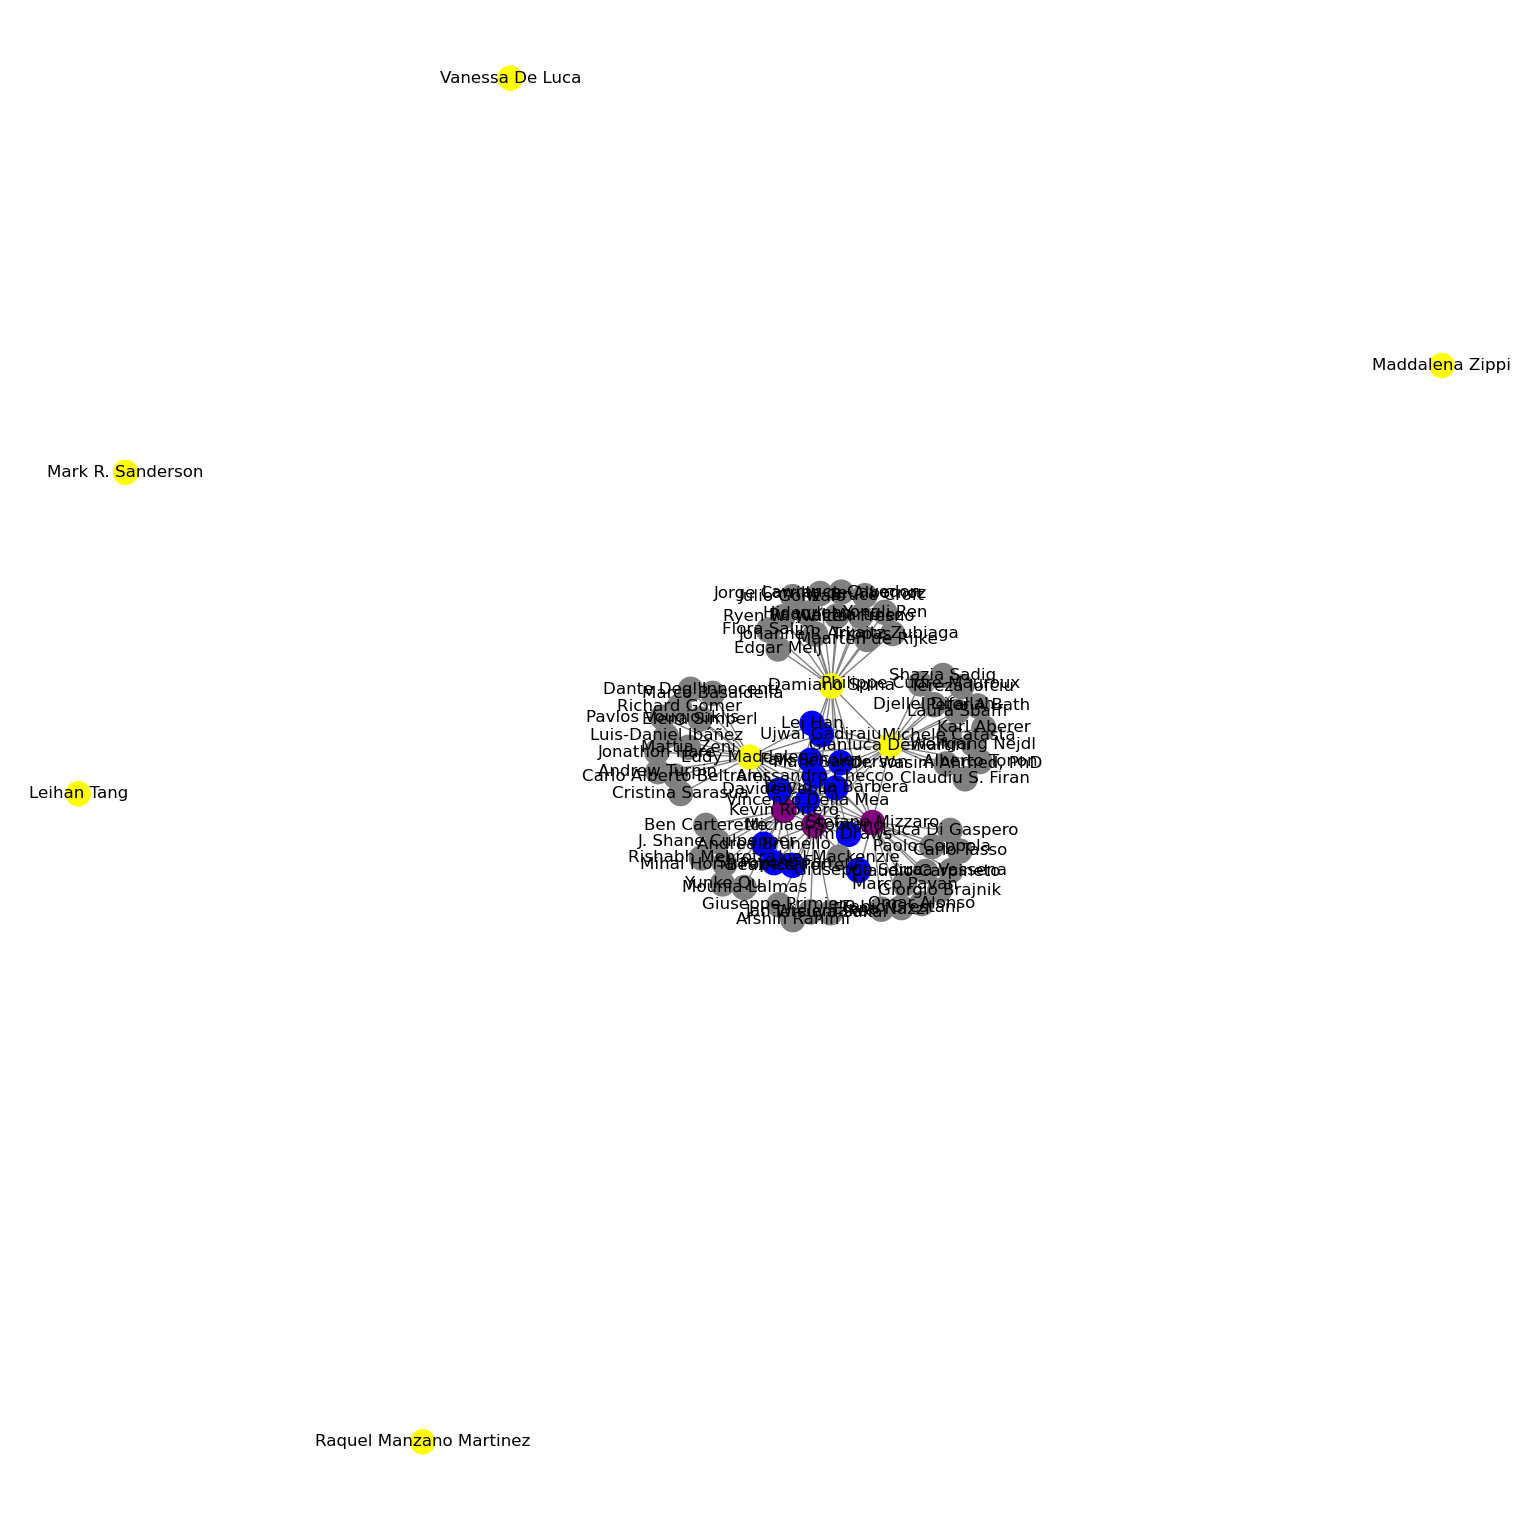

In [15]:
##3.b
## Visualizzare il grafo

## Logica per la gestione dei colori

def Choose_Node_Color(Graph):
        color = {}
    
        for node in Graph.nodes():
                degree= Graph.degree[node]
                if degree == 1:
                        color[node] = 'gray'           
                elif 2 <= degree <= 10:
                        color[node]='blue'
                elif 11 <= degree <= 20:
                        color[node]= 'purple'
                else:
                        color[node]= 'yellow'

        return list(color.values())

plt.figure(figsize=(15, 15))

## Ogni nodo viene aggiunto un attributo "color" (stringa) che ne identifica il colore nel grafico
for node, color in zip(coautorship_graph.nodes(), Choose_Node_Color(coautorship_graph)):
    coautorship_graph.nodes[node]['label'] = str(node)
    coautorship_graph.nodes[node]['color'] = color

## parametri di visualizzazione
nx.draw(coautorship_graph,
        pos=nx.spring_layout(coautorship_graph),
        node_color= [coautorship_graph.nodes[node]['color'] for node in coautorship_graph.nodes],
        edge_color='grey',
        width=1,
        with_labels=True
        )

## Salvataggio del grafo in pdf
plt.savefig("visualizations\\first_graph.pdf")

plt.show()

4. A partire dal grafo prodotto al punto 3:

a. Generarne un secondo dove il numero di nodi è lo stesso, mentre il numero di archi è aumentato di 50 utilizzando la tecnica del Preferential Attachment.
Salvare il grafo in locale nella cartella /graphs.

b. Visualizzare e salvare il nuovo grafo come fatto al punto 3b

In [16]:
##4.a

## Come base viene usato il grafo precedente


extended_coautorship_graph = coautorship_graph.copy()

new_edges_list = list(nx.preferential_attachment(extended_coautorship_graph))

new_edges_list.sort(key= lambda x:x[2], ## ordina in base al valore p di preferential_attachment
                    reverse=True
                    )

new_edges_tuple  = [(item[0], item[1]) for item in new_edges_list[:50]]

extended_coautorship_graph.add_edges_from(new_edges_tuple)

## Salvataggio grafo
with open('graphs\\extended_coauthorship_graph.gpickle', 'wb') as file:
    pickle.dump(extended_coautorship_graph, file)


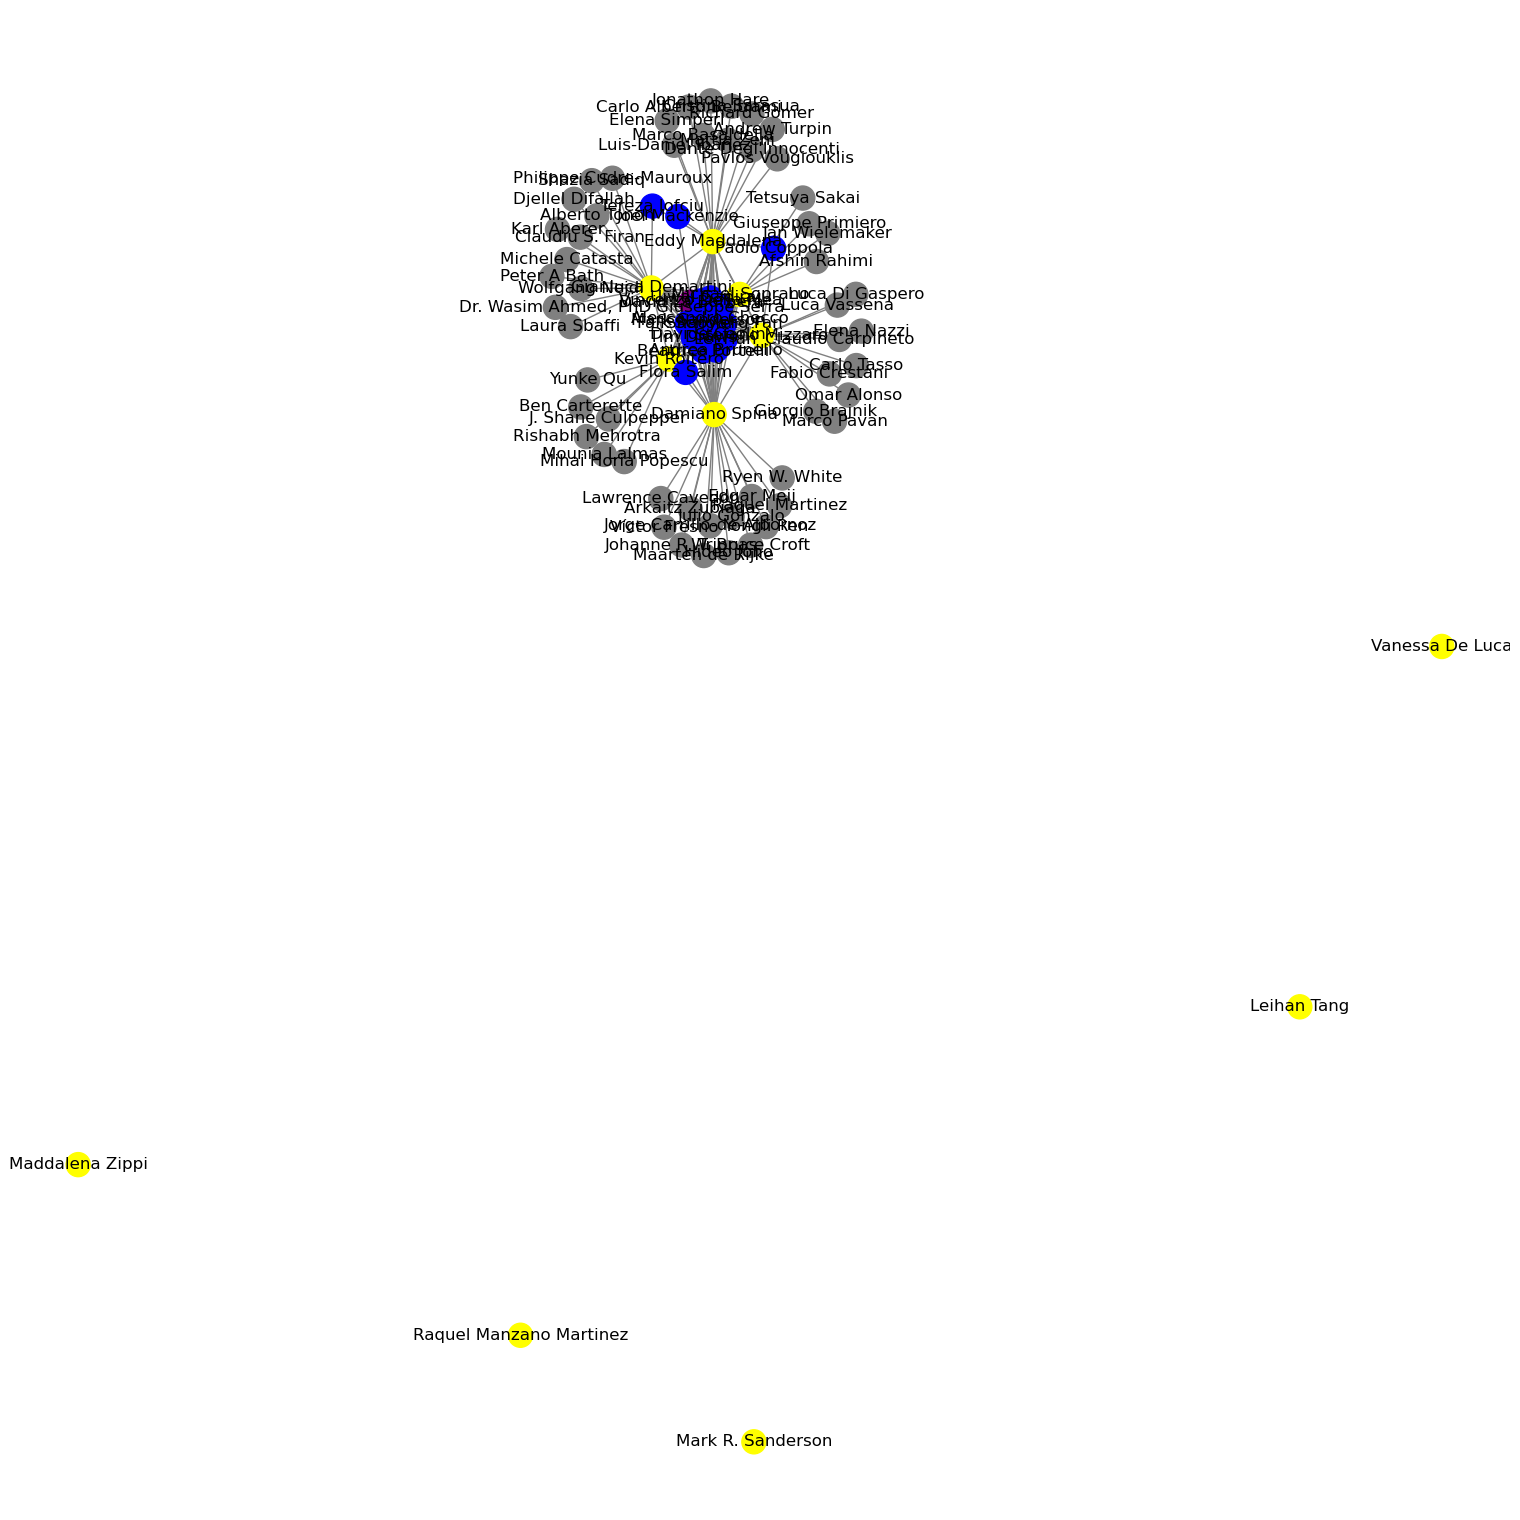

In [17]:
## 4.b

## Stampa del grafo... 
plt.figure(figsize=(15, 15))

## Ogni nodo viene aggiunto un attributo "color" (stringa) che ne identifica il colore nel grafico
for node, color in zip(extended_coautorship_graph.nodes(), Choose_Node_Color(extended_coautorship_graph)):
    extended_coautorship_graph.nodes[node]['label'] = str(node)
    extended_coautorship_graph.nodes[node]['color'] = color

## parametri di visualizzazione
nx.draw(extended_coautorship_graph,
        pos=nx.spring_layout(extended_coautorship_graph),
        node_color= [extended_coautorship_graph.nodes[node]['color'] for node in extended_coautorship_graph.nodes],
        edge_color='grey',
        width=1,
        with_labels=True
        )

## save grafo...
plt.savefig("visualizations\\extended_graph.pdf")

plt.show()

5. Per entrambi i grafi prodotti calcolare:
    - Coefficiente di clustering medio
    - Centro del grafo
    - Raggio
    - Distanza Media
    - Transitività
    - Coefficienti Omega e Sigma, per stimare la “small-world-ness”
    - Riassumere le informazioni in un DataFrame, dove ogni riga rappresenta le informazioni relative ad un grafo, ed ogni colonna le informazioni relative ad una misura calcolata per quel grafo. Salvare nella cartella /results tale DataFrame.


In [18]:
datiGrafo1 = {
    "nome" : "coautorship_graph",
    "clustering_medio": nx.average_clustering(coautorship_graph),
    "centro": ", ".join(nx.center(coautorship_graph)),              # conversione in stringa
    "raggio": nx.radius(coautorship_graph),
    "distanza_media": nx.average_shortest_path_length(coautorship_graph),
    "transitivita": nx.transitivity(coautorship_graph),
    "coeff_omega": nx.omega(coautorship_graph),
    "coeff_sigma": nx.sigma(coautorship_graph)
}

datiGrafo2 = {
    "nome" : "extended_coautorship_graph",
    "clustering_medio": nx.average_clustering(extended_coautorship_graph),
    "centro": ", ".join(nx.center(extended_coautorship_graph)),     # conversione in stringa
    "raggio": nx.radius(extended_coautorship_graph),
    "distanza_media": nx.average_shortest_path_length(extended_coautorship_graph),
    "transitivita": nx.transitivity(extended_coautorship_graph),
    "coeff_omega": nx.omega(extended_coautorship_graph),
    "coeff_sigma": nx.sigma(extended_coautorship_graph)
}

dataFrameGrafo1 = pd.DataFrame(datiGrafo1, index=[0])
dataFrameGrafo2 = pd.DataFrame(datiGrafo2, index=[0])
dfMisure = pd.concat([dataFrameGrafo1, dataFrameGrafo2])
dfMisure.to_csv("results\\overall_measures.csv", index = False)

NetworkXError: Found infinite path length because the graph is not connected

6. Per entrambi i grafi prodotti calcolare per ogni nodo:
- Degree Centrality
- Betweenness Centrality
- Closeness Centrality
- Pagerank
- HITS, per calcolare i valori di hubness e authority
- Riassumere le due informazioni in un DataFrame per ciascun grafo, dove ogni riga rappresenta le informazioni relative ad un nodo, ed ogni colonna le 
informazioni relative ad una misura calcolata per quel nodo. 
Salvare nella cartella /results tali DataFrame.

In [ ]:
#calcolo degli indici in quest'ordine:
#1- degree centrality
#2- betweenness centrality
#3- closeness centrality
#4- page-rank
#5- HITS

degree_centrality_coautorship_graph=nx.degree_centrality(coautorship_graph)
degree_centrality_extended_coautorship_graph=nx.degree_centrality(extended_coautorship_graph)

betweennes_centrality_coautorship_graph=nx.betweenness_centrality(coautorship_graph)
betweennes_centrality_extended_coautorship_graph=nx.betweenness_centrality(extended_coautorship_graph)

closeness_centrality_coautorship_graph=nx.closeness_centrality(coautorship_graph)
closeness_centrality_extended_coautorship_graph=nx.closeness_centrality(extended_coautorship_graph)

page_rank_coautorship_graph=nx.pagerank(coautorship_graph)
page_rank_extended_coautorship_graph=nx.pagerank(extended_coautorship_graph)

hits_coautorship_graph=nx.hits(coautorship_graph)
hits_extended_coautorship_graph=nx.hits(extended_coautorship_graph)

hubs_coautorship,authorities_coautorship=hits_coautorship_graph
hubs_extended_coautorship,authorities_extended_coautorship=hits_extended_coautorship_graph

#creazione dei dataframe
coautorship = {
    'Nodi' : degree_centrality_coautorship_graph.keys(),
    'Degree Centrality' : degree_centrality_coautorship_graph.values(),
    'Betweenness Centrality' : betweennes_centrality_coautorship_graph.values(),
    'Closeness Centrality' : closeness_centrality_coautorship_graph.values(),
    'Page Rank' : page_rank_coautorship_graph.values(),
    'HITS Hubs' : hubs_coautorship.values(),
    'HITS Authorities' : authorities_coautorship.values()
}

coauthorship_df = pd.DataFrame(coautorship)

extended_coauthorship = {
    'Nodi' : degree_centrality_extended_coautorship_graph.keys(),
    'Degree Centrality' : degree_centrality_extended_coautorship_graph.values(),
    'Betweenness Centrality' : betweennes_centrality_extended_coautorship_graph.values(),
    'Closeness Centrality' : closeness_centrality_extended_coautorship_graph.values(),
    'Page Rank' : page_rank_extended_coautorship_graph.values(),
    'HITS Hubs' : hubs_extended_coautorship.values(),
    'HITS Authorities' : authorities_extended_coautorship.values()

}

coauthorship_extended_df = pd.DataFrame(extended_coauthorship)

display(coauthorship_df)
display(coauthorship_extended_df)

#creazione dei file
coauthorship_df.to_csv("results\\first_graph_centralities.csv", index = False)
coauthorship_extended_df.to_csv("results\\extended_graph_centralities.csv", index = False)

#------------------------------------------------------------------------------------
#Calcolo valori massimi/minimi/medie coauthorship/extended coauthorship
maxValuesCoauthorship = {
    'Indici' : ['Degree Centrality' , 'Betweenness Centrality' , 'Closeness Centrality' , 'Page Rank' , 'HITS Hubs' , 'HITS Authorities'],
    'Nodo' : [coauthorship_df['Nodi'].iloc[coauthorship_df['Degree Centrality'].idxmax()] , coauthorship_df['Nodi'].iloc[coauthorship_df['Betweenness Centrality'].idxmax()] , 
              coauthorship_df['Nodi'].iloc[coauthorship_df['Closeness Centrality'].idxmax()] , coauthorship_df['Nodi'].iloc[coauthorship_df['Page Rank'].idxmax()] , 
              coauthorship_df['Nodi'].iloc[coauthorship_df['HITS Hubs'].idxmax()] , coauthorship_df['Nodi'].iloc[coauthorship_df['HITS Authorities'].idxmax()]],
    'Valore' : [coauthorship_df['Degree Centrality'].max() , coauthorship_df['Betweenness Centrality'].max() , coauthorship_df['Closeness Centrality'].max() , coauthorship_df['Page Rank'].max() , 
                coauthorship_df['HITS Hubs'].max() , coauthorship_df['HITS Authorities'].max()]
}

maxValuesExtendedCoauthorship = {
    'Indici' : ['Degree Centrality' , 'Betweenness Centrality' , 'Closeness Centrality' , 'Page Rank' , 'HITS Hubs' , 'HITS Authorities'],
    'Nodo' : [coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Degree Centrality'].idxmax()] , coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Betweenness Centrality'].idxmax()] , 
              coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Closeness Centrality'].idxmax()] , coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Page Rank'].idxmax()] , 
              coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['HITS Hubs'].idxmax()] , coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['HITS Authorities'].idxmax()]],
    'Valore' : [coauthorship_extended_df['Degree Centrality'].max() , coauthorship_extended_df['Betweenness Centrality'].max() , coauthorship_extended_df['Closeness Centrality'].max() , coauthorship_extended_df['Page Rank'].max() , 
                coauthorship_extended_df['HITS Hubs'].max() , coauthorship_extended_df['HITS Authorities'].max()]
}

minValuesCoauthorship = {
    'Indici' : ['Degree Centrality' , 'Betweenness Centrality' , 'Closeness Centrality' , 'Page Rank' , 'HITS Hubs' , 'HITS Authorities'],
    'Nodo' : [coauthorship_df['Nodi'].iloc[coauthorship_df['Degree Centrality'].idxmin()] , coauthorship_df['Nodi'].iloc[coauthorship_df['Betweenness Centrality'].idxmin()] , 
              coauthorship_df['Nodi'].iloc[coauthorship_df['Closeness Centrality'].idxmin()] , coauthorship_df['Nodi'].iloc[coauthorship_df['Page Rank'].idxmin()] , 
              coauthorship_df['Nodi'].iloc[coauthorship_df['HITS Hubs'].idxmin()] , coauthorship_df['Nodi'].iloc[coauthorship_df['HITS Authorities'].idxmin()]],
    'Valore' : [coauthorship_df['Degree Centrality'].min() , coauthorship_df['Betweenness Centrality'].min() , coauthorship_df['Closeness Centrality'].min() , coauthorship_df['Page Rank'].min() , 
                coauthorship_df['HITS Hubs'].min() , coauthorship_df['HITS Authorities'].min()]
}

minValuesExtendedCoauthorship = {
    'Indici' : ['Degree Centrality' , 'Betweenness Centrality' , 'Closeness Centrality' , 'Page Rank' , 'HITS Hubs' , 'HITS Authorities'],
    'Nodo' : [coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Degree Centrality'].idxmin()] , coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Betweenness Centrality'].idxmin()] , 
              coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Closeness Centrality'].idxmin()] , coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Page Rank'].idxmin()] , 
              coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['HITS Hubs'].idxmin()] , coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['HITS Authorities'].idxmin()]],
    'Valore' : [coauthorship_extended_df['Degree Centrality'].min() , coauthorship_extended_df['Betweenness Centrality'].min() , coauthorship_extended_df['Closeness Centrality'].min() , coauthorship_extended_df['Page Rank'].min() , 
                coauthorship_extended_df['HITS Hubs'].min() , coauthorship_extended_df['HITS Authorities'].min()]
}

meanValuesCoauthorship = {
    'Indici' : ['Degree Centrality' , 'Betweenness Centrality' , 'Closeness Centrality' , 'Page Rank' , 'HITS Hubs' , 'HITS Authorities'],
    'Medie' : [coauthorship_df['Degree Centrality'].mean() , coauthorship_df['Betweenness Centrality'].mean() , coauthorship_df['Closeness Centrality'].mean() , coauthorship_df['Page Rank'].mean(),
               coauthorship_df['HITS Hubs'].mean() , coauthorship_df['HITS Authorities'].mean()]
}

meanValuesExtendedCoauthorship = {
    'Indici' : ['Degree Centrality' , 'Betweenness Centrality' , 'Closeness Centrality' , 'Page Rank' , 'HITS Hubs' , 'HITS Authorities'],
    'Medie' : [coauthorship_extended_df['Degree Centrality'].mean() , coauthorship_extended_df['Betweenness Centrality'].mean() , coauthorship_extended_df['Closeness Centrality'].mean(), 
               coauthorship_extended_df['Page Rank'].mean() , coauthorship_extended_df['HITS Hubs'].mean() , coauthorship_extended_df['HITS Authorities'].mean()]
}

maxValuesCoauthorshipDF = pd.DataFrame(maxValuesCoauthorship)
maxValuesExtendedCoauthorshipDF = pd.DataFrame(maxValuesExtendedCoauthorship)
minValuesCoauthorshipDF = pd.DataFrame(minValuesCoauthorship) 
minValuesExtendedCoauthorshipDF = pd.DataFrame(minValuesExtendedCoauthorship)
meanValuesCoauthorshipDF = pd.DataFrame(meanValuesCoauthorship)
meanValuesExtendedCoauthorshipDF = pd.DataFrame(meanValuesExtendedCoauthorship)


print("MAX VALUES COAUTHORSHIP")
display(maxValuesCoauthorshipDF)
print("MAX VALUES EXTENDED COAUTHORSHIP")
display(maxValuesExtendedCoauthorshipDF)
print("MIN VALUES COAUTHORSHIP")
display(minValuesCoauthorshipDF)
print("MIN VALUES EXTENDED COAUTHORSHIP")
display(minValuesExtendedCoauthorshipDF)
print("MEAN VALUES COAUTHORSHIP")
display(meanValuesCoauthorshipDF)
print("MEAN VALUES EXTENDED COAUTHORSHIP")
display(meanValuesExtendedCoauthorshipDF)




,Nodi,Degree Centrality,Betweenness Centrality,Closeness Centrality,Page Rank,HITS Hubs,HITS Authorities
0,David La Barbera,0.118421,0.041589,0.496732,0.034056,0.043469,0.043469
1,Michael Soprano,0.236842,0.196113,0.567164,0.069596,0.060250,0.060250
2,Kevin Roitero,0.263158,0.216264,0.575758,0.077502,0.065121,0.065121
3,Stefano Mizzaro,0.263158,0.281644,0.575758,0.083657,0.058448,0.058448
4,Damiano Spina,0.276316,0.341322,0.539007,0.094931,0.048934,0.048934
...,...,...,...,...,...,...,...
72,Dante Degl'Innocenti,0.013158,0.000000,0.343891,0.005479,0.006484,0.006484
73,Pavlos Vougiouklis,0.013158,0.000000,0.343891,0.005479,0.006484,0.006484
74,Jonathon Hare,0.013158,0.000000,0.343891,0.005479,0.006484,0.006484
75,Carlo Alberto Beltrami,0.013158,0.000000,0.343891,0.005479,0.006484,0.006484


,Nodi,Degree Centrality,Betweenness Centrality,Closeness Centrality,Page Rank,HITS Hubs,HITS Authorities
0,David La Barbera,0.118421,0.014827,0.496732,0.024505,0.025504,0.025504
1,Michael Soprano,0.250000,0.116383,0.571429,0.052861,0.042892,0.042892
2,Kevin Roitero,0.276316,0.100500,0.580153,0.057053,0.047067,0.047067
3,Stefano Mizzaro,0.263158,0.123617,0.575758,0.057471,0.037412,0.037412
4,Damiano Spina,0.276316,0.177814,0.562963,0.064494,0.037886,0.037886
...,...,...,...,...,...,...,...
72,Dante Degl'Innocenti,0.013158,0.000000,0.455090,0.006862,0.010682,0.010682
73,Pavlos Vougiouklis,0.026316,0.000000,0.455090,0.006862,0.010682,0.010682
74,Jonathon Hare,0.013158,0.000000,0.361905,0.004435,0.004039,0.004039
75,Carlo Alberto Beltrami,0.013158,0.000000,0.455090,0.006862,0.010682,0.010682


MAX VALUES COAUTHORSHIP


,Indici,Nodo,Valore
0,Degree Centrality,Damiano Spina,0.276316
1,Betweenness Centrality,Damiano Spina,0.341322
2,Closeness Centrality,Gianluca Demartini,0.580153
3,Page Rank,Damiano Spina,0.094931
4,HITS Hubs,Kevin Roitero,0.065121
5,HITS Authorities,Kevin Roitero,0.065121


MAX VALUES EXTENDED COAUTHORSHIP


,Indici,Nodo,Valore
0,Degree Centrality,Julio Gonzalo,0.671053
1,Betweenness Centrality,Julio Gonzalo,0.474670
2,Closeness Centrality,Julio Gonzalo,0.716981
3,Page Rank,Julio Gonzalo,0.145627
4,HITS Hubs,Julio Gonzalo,0.068953
5,HITS Authorities,Julio Gonzalo,0.068953


MIN VALUES COAUTHORSHIP


,Indici,Nodo,Valore
0,Degree Centrality,Joel Mackenzie,0.013158
1,Betweenness Centrality,Tim Draws,0.000000
2,Closeness Centrality,Joel Mackenzie,0.333333
3,Page Rank,Joel Mackenzie,0.005165
4,HITS Hubs,Joel Mackenzie,0.005170
5,HITS Authorities,Joel Mackenzie,0.005170


MIN VALUES EXTENDED COAUTHORSHIP


,Indici,Nodo,Valore
0,Degree Centrality,Afshin Rahimi,0.013158
1,Betweenness Centrality,Tim Draws,0.000000
2,Closeness Centrality,Lawrence Cavedon,0.361905
3,Page Rank,Ben Carterette,0.004257
4,HITS Hubs,Philippe Cudre-Mauroux,0.003521
5,HITS Authorities,Michele Catasta,0.003521


MEAN VALUES COAUTHORSHIP


,Indici,Medie
0,Degree Centrality,0.037936
1,Betweenness Centrality,0.022023
2,Closeness Centrality,0.383647
3,Page Rank,0.012987
4,HITS Hubs,0.012987
5,HITS Authorities,0.012987


MEAN VALUES EXTENDED COAUTHORSHIP


,Indici,Medie
0,Degree Centrality,0.055024
1,Betweenness Centrality,0.017111
2,Closeness Centrality,0.446138
3,Page Rank,0.012987
4,HITS Hubs,0.012987
5,HITS Authorities,0.012987


7. Produrre una visualizzazione interattiva con PyVis dei due grafi con colorazioni di
nodi ed archi a piacimento. Salvare i due output in formato HTML nella cartella
/visualizations.

In [ ]:
## Save grafo interattivo

## Creazione grafo con area di stampa
interactive_first_graph= pv.network.Network(height= '600px', 
                       width='100%')
    
## Conversione per Pyvis
interactive_first_graph.from_nx(coautorship_graph)
interactive_first_graph.save_graph('visualizations\\interactive_first_graph.html')

####################################
## Ripeti sopra per secondo grafo...
interactive_extended_graph= pv.network.Network(height= '600px', 
                       width='100%')


interactive_extended_graph.from_nx(extended_coautorship_graph)
interactive_extended_graph.save_graph('visualizations\\interactive_extended_graph.html')

Analisi comparativa reti

(array([58., 12.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  3.]),
 array([0.01315789, 0.05526316, 0.09736842, 0.13947368, 0.18157895,
        0.22368421, 0.26578947, 0.30789474, 0.35      , 0.39210526,
        0.43421053]),
 <BarContainer object of 10 artists>)

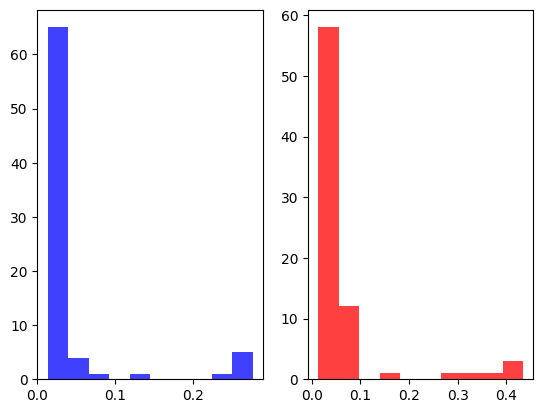

In [ ]:
## Degree Centrality

plt.subplot(1, 2, 1)
plt.hist(coauthorship_df['Degree Centrality'], 
         alpha=0.75,
         bins=10,
         color='blue')

plt.subplot(1, 2, 2)
plt.hist(coauthorship_extended_df['Degree Centrality'], 
         alpha=0.75,
         bins=10,
         color= 'red')


(array([71.,  0.,  0.,  0.,  2.,  0.,  1.,  1.,  0.,  2.]),
 array([0.        , 0.03304887, 0.06609774, 0.09914662, 0.13219549,
        0.16524436, 0.19829323, 0.23134211, 0.26439098, 0.29743985,
        0.33048872]),
 <BarContainer object of 10 artists>)

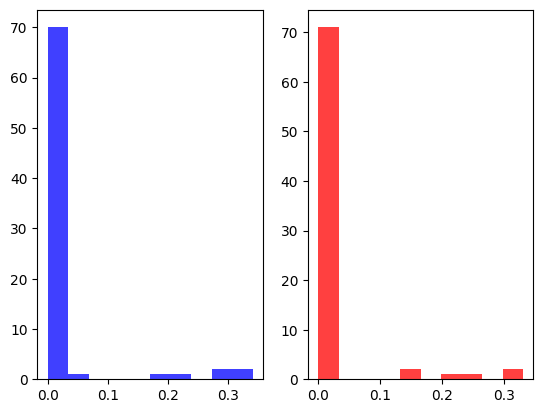

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(coauthorship_df['Betweenness Centrality'], 
         alpha=0.75,
         bins=10,
         color= 'blue')

plt.subplot(1, 2, 2)
plt.hist(coauthorship_extended_df['Betweenness Centrality'], 
         alpha=0.75,
         bins=10,
         color= 'red')

(array([21., 35.,  1.,  0.,  1., 12.,  1.,  0.,  2.,  4.]),
 array([0.35514019, 0.38349171, 0.41184324, 0.44019477, 0.4685463 ,
        0.49689782, 0.52524935, 0.55360088, 0.58195241, 0.61030393,
        0.63865546]),
 <BarContainer object of 10 artists>)

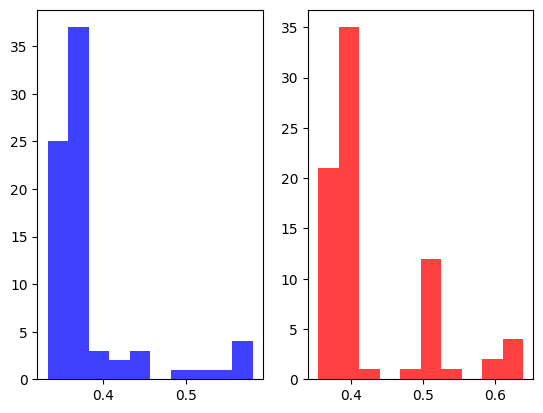

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(coauthorship_df['Closeness Centrality'], 
         alpha=0.75,
         bins=10,
         color= 'blue')

plt.subplot(1, 2, 2)
plt.hist(coauthorship_extended_df['Closeness Centrality'], 
         alpha=0.75,
         bins=10,
         color= 'red')

(array([56.,  1.,  1.,  0., 12.,  0.,  1.,  0.,  0.,  6.]),
 array([0.00323357, 0.00880887, 0.01438418, 0.01995948, 0.02553479,
        0.03111009, 0.03668539, 0.0422607 , 0.047836  , 0.05341131,
        0.05898661]),
 <BarContainer object of 10 artists>)

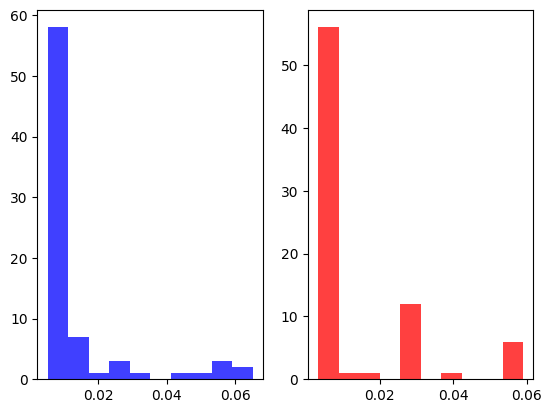

In [ ]:

plt.subplot(1, 2, 1)
plt.hist(coauthorship_df['HITS Hubs'], 
         alpha=0.75,
         bins=10,
         color= 'blue')

plt.subplot(1, 2, 2)
plt.hist(coauthorship_extended_df['HITS Hubs'], 
         alpha=0.75,
         bins=10,
         color= 'red')

(array([56.,  1.,  1.,  0., 12.,  0.,  1.,  0.,  0.,  6.]),
 array([0.00323357, 0.00880887, 0.01438418, 0.01995948, 0.02553479,
        0.03111009, 0.03668539, 0.0422607 , 0.047836  , 0.05341131,
        0.05898661]),
 <BarContainer object of 10 artists>)

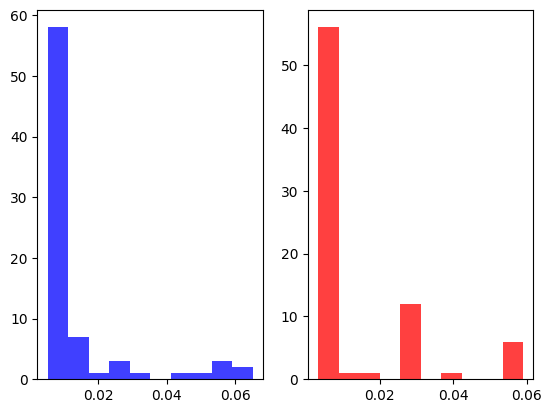

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(coauthorship_df['HITS Hubs'], 
         alpha=0.75,
         bins=10,
         color= 'blue')

plt.subplot(1, 2, 2)
plt.hist(coauthorship_extended_df['HITS Hubs'], 
         alpha=0.75,
         bins=10,
         color= 'red')

(array([56.,  1.,  1.,  0., 12.,  0.,  1.,  0.,  0.,  6.]),
 array([0.00323357, 0.00880887, 0.01438418, 0.01995948, 0.02553479,
        0.03111009, 0.03668539, 0.0422607 , 0.047836  , 0.05341131,
        0.05898661]),
 <BarContainer object of 10 artists>)

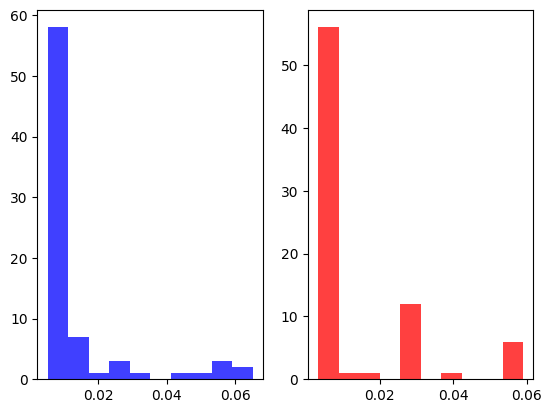

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(coauthorship_df['HITS Authorities'], 
         alpha=0.75,
         bins=10,
         color= 'blue')

plt.subplot(1, 2, 2)
plt.hist(coauthorship_extended_df['HITS Authorities'], 
         alpha=0.75,
         bins=10,
         color= 'red')